In [20]:
import torch
import torchvision
import os
import pickle
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image
from torchcam.methods import SmoothGradCAMpp
from utils import imread, isfile, im_to_txt_path
from timer import *
from torchvision.transforms import transforms as T
import cv2
import numpy as np
import random
import torch.nn.functional as F

parent_dir = 'rois2/'
obj_dir = parent_dir + 'objects/'
img_dir = parent_dir + 'images/'
label_dir = parent_dir + 'labels/'
model_dir = parent_dir + 'models/'

obj_train_dir = obj_dir + 'train/'
obj_val_dir = obj_dir + 'val/'

result_dir = parent_dir + 'results/'
os.makedirs(result_dir, exist_ok=True)
model1_result_dir = result_dir + 'model1/'
os.makedirs(model1_result_dir, exist_ok=True)
model2_result_dir = result_dir + 'model2/'
os.makedirs(model2_result_dir, exist_ok=True)

bkg = 0


In [21]:
mean_std_dict = pickle.load(open(img_dir + 'mean_std.pkl', 'rb'))
print(mean_std_dict)

{'expert1_id-6381471f7f8a5e686a52765f_left-36214_top-41262_right-39265_bottom-46232': (array([0.88391932, 0.86455804, 0.84128348]), array([0.08340014, 0.09904173, 0.12370593])), 'expert1_id-6381471f7f8a5e686a52765f_left-36627_top-47431_right-39464_bottom-52356': (array([0.8841721 , 0.86190506, 0.83281352]), array([0.08451419, 0.10180634, 0.1258441 ])), 'expert1_id-6381471f7f8a5e686a527706_left-75035_top-24698_right-80405_bottom-28610': (array([0.86614397, 0.84570188, 0.82592797]), array([0.10124425, 0.11657547, 0.1331032 ])), 'expert1_id-6381471f7f8a5e686a5277c2_left-68060_top-39334_right-73669_bottom-44184': (array([0.89545478, 0.87718601, 0.86096679]), array([0.06975292, 0.08177992, 0.09553303])), 'expert1_id-6381471f7f8a5e686a52781f_left-70416_top-29678_right-75686_bottom-33272': (array([0.81283723, 0.75033681, 0.66633584]), array([0.12331021, 0.1447023 , 0.17060996])), 'expert1_id-638147207f8a5e686a527923_left-84307_top-28200_right-89535_bottom-31674': (array([0.71946232, 0.6813055

In [22]:
ratio = []
dirs = os.listdir(obj_train_dir)
for dir in dirs:
    if os.path.isdir(obj_train_dir+ dir):
        # print(len(os.listdir(obj_dir + dir)))
        ratio.append(len(os.listdir(obj_train_dir + dir)))
print(ratio)


[489897, 6731]


In [23]:
ratio = []
dirs = os.listdir(obj_val_dir)
for dir in dirs:
    if os.path.isdir(obj_val_dir+ dir):
        # print(len(os.listdir(obj_dir + dir)))
        ratio.append(len(os.listdir(obj_val_dir + dir)))
print(ratio)

[104633, 1474]


In [24]:
from PIL import Image
def custom_loader(path):
    return path

orig_train_dataset = datasets.ImageFolder(root=obj_train_dir,loader=custom_loader)

orig_val_dataset = datasets.ImageFolder(root=obj_val_dir,loader=custom_loader)

In [25]:
def crop_name_to_roi_name(crop_name):
    return (crop_name.split('__')[0]).split('\\')[-1]

In [26]:
from collections import Counter
class_num = len(orig_train_dataset.classes)

In [23]:
# # Balance train dataset by extending the minority classes

# print('train dataset: ')
# print('     unbalanced:')

# class_counts = Counter([label for _, label in orig_train_dataset.samples])
# max_count = max(class_counts.values())
# print('     ', class_counts)

# print('     balanced:')
# import random
# # Create a new dataset to store balanced data
# balanced_train_dataset = []

# for label in class_counts:
#     indices = [i for i, (_, lbl) in enumerate(orig_train_dataset.samples) if lbl == label]
    
#     # Calculate how many more samples are needed to balance the class
#     additional_samples_needed = max_count - class_counts[label]
    
#     # Oversample the class by randomly duplicating images
#     if additional_samples_needed > 0:
#         additional_samples = random.choices(indices, k=additional_samples_needed)
#         indices.extend(additional_samples)
    
#     balanced_train_dataset.extend([orig_train_dataset[i] for i in indices])

# # Shuffle the balanced dataset
# random.shuffle(balanced_train_dataset)
# class_counts = Counter([label for _, label in balanced_train_dataset])
# print('     ', class_counts)


In [24]:
# # Balance val dataset by shortening the majority classes
# print('val dataset: ')
# print('     unbalanced:')

# class_counts = Counter([label for _, label in orig_val_dataset.samples])
# min_count = min(class_counts.values())
# print('     ', class_counts)

# print('     balanced:')
# import random
# # Create a new dataset to store balanced data
# balanced_indices = []
# balanced_val_dataset = []
# for label in class_counts:
#     indices = [i for i, (_, lbl) in enumerate(orig_val_dataset.samples) if lbl == label]
    
#     if min_count > 0:
#         balanced_indices.extend(random.choices(indices, k=min_count))
    
# balanced_val_dataset.extend([orig_val_dataset[i] for i in balanced_indices])

# # Shuffle the balanced dataset
# random.shuffle(balanced_val_dataset)
# class_counts = Counter([label for _, label in balanced_val_dataset])
# print('     ', class_counts)

In [27]:
class CustomDataset(Dataset):

    def __init__(self, inputs_list_pos, inputs_list_neg, length, positive_prob = 0.5):
        
        self.positives = inputs_list_pos
        self.negatives = inputs_list_neg
        self.positive_prob = positive_prob
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # print(self.inputs_list[idx])
        item = random.choices([random.choice(self.positives), random.choice(self.negatives)], weights=[self.positive_prob, 1-self.positive_prob],k=1)[0]
        path = item[0]
        roi_name = crop_name_to_roi_name(path)
        if roi_name in mean_std_dict.keys():
            mean, std = mean_std_dict[roi_name]
        else:
            print('mean std not found')
            print(roi_name)
            
        label = item[1]
        image = Image.open(path)
        
        transf = v2.Compose([
            v2.ToImage(), 
            v2.ToDtype(torch.float32, scale=True),
            v2.Resize((260,260)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),
            v2.RandomAffine(degrees=(0,90), translate=(0.1,0.3), scale=(0.5,0.75)),
            v2.Normalize(mean=mean, std=std), # aim to make the mean = 0 and std = 1
           
        ])
        image = transf(image)

        return image, label

In [28]:
train_dataset_positives = []
train_dataset_negatives = []
for item in orig_train_dataset.samples:
    if item[1] == 1:
        train_dataset_positives.append(item)
    else:
        train_dataset_negatives.append(item)

val_dataset_positives = []
val_dataset_negatives = []
for item in orig_val_dataset.samples:
    if item[1] == 1:
        val_dataset_positives.append(item)
    else:
        val_dataset_negatives.append(item)
        

train_dataset = CustomDataset(train_dataset_positives, train_dataset_negatives,320000)

val_dataset = CustomDataset(val_dataset_positives, val_dataset_negatives, 32000, positive_prob=0.1)

In [10]:
train_loader, val_loader = DataLoader(train_dataset, batch_size=32, shuffle=False), DataLoader(val_dataset, batch_size=32, shuffle=False)
print('train loader length: ', len(train_loader))
print('val loader length: ', len(val_loader))

train loader length:  10000
val loader length:  2000


In [11]:
from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

def train_classification_model(model, train_loader, val_loader, save_model_dir, begin_epoch = 1,num_epochs=10,class_weights=None, train = True, val = True):
    
    accuracy_list = [None]*num_epochs
    precision_list = [None]*num_epochs
    recall_list = [None]*num_epochs
    train_loss_list = [None]*num_epochs
    learning_rate_list = [None]*num_epochs
    
    model.to('cuda')
    criterion = torch.nn.CrossEntropyLoss(weight = class_weights).to('cuda')
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3
                                  , weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
    if begin_epoch > 1:
        model.load_state_dict(torch.load(save_model_dir + 'round3_model_epoch' + str(begin_epoch-1) + '.pth'))
    for epoch in range(begin_epoch, begin_epoch + num_epochs):
        if train:
            # Train the model
            model.train()
            train_loss = 0
            cnt = 0 
            print('Training model...')
            for i, (images, labels) in enumerate(train_loader):
                images = images.to('cuda')
                labels = labels.to('cuda')
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs.float(), labels)
                
                train_loss += loss.item()
                cnt += 1
                
                loss.backward()
                optimizer.step()
                model_path = save_model_dir + 'round3_model_epoch' + str(epoch) + '.pth'
                
                if (i + 1)%500 == 0 or i == len(train_loader)-1:
                    print('     Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Learning Rate: {}'
                        .format(epoch, num_epochs, i+1, len(train_loader), loss.item(), optimizer.param_groups[0]['lr']))
            train_loss /= cnt
            train_loss_list[epoch-1] = train_loss
            learning_rate_list[epoch-1] = optimizer.param_groups[0]['lr']
            torch.save(model.state_dict(), model_path)
        
        if val:    
            model.load_state_dict(torch.load(save_model_dir + 'round3_model_epoch' + str(epoch) + '.pth'))
            # Validation
            model.eval()
            print('Validation...')
            
            # Calculate accuracy
            correct = 0
            total = 0
            # Calculate recall
            true_pos_obj = 0
            correct_pos_pred = 0
            pos_pred = 0
            with torch.no_grad():
                for i, (images, labels) in enumerate(val_loader):
                    images = images.to('cuda')
                    labels = labels.to('cuda')
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    true_pos_obj += (labels != bkg).sum().item()
                    correct_pos_pred += ((predicted == labels) & (labels != bkg)).sum().item()
                    pos_pred += (predicted != bkg).sum().item()
                    
                    if(i+1) % 500 == 0 or i == len(val_loader)-1:
                        print('     Epoch [{}/{}], Image [{}/{}], Accuracy: {:.2f} %, Recall: {:.2f} %, Precision: {:.2f} %'
                                .format(epoch, num_epochs, i+1, len(val_loader), 100 * correct / total, 100 * correct_pos_pred / true_pos_obj, 100 * correct_pos_pred / pos_pred))
                    
            print('\n')        
            print('total: ', total, 'correct: ', correct, 'true_pos_obj: ', true_pos_obj, 'correct_pos_pred: ', correct_pos_pred, 'pos_pred: ', pos_pred)
            print('Accuracy of the network on the validation images: {} % '.format(100 * correct / total))
            print('Recall of the network on the validation images: {} % '.format(100 * correct_pos_pred / true_pos_obj))
            print('Precision of the network on the validation images: {} % '.format(100 * correct_pos_pred / pos_pred))    
            accuracy_list[epoch-1] = correct / total
            pickle.dump(accuracy_list, open(save_model_dir + 'accuracy_list.pkl', 'wb'))
            recall_list[epoch-1] = correct_pos_pred / true_pos_obj
            pickle.dump(recall_list, open(save_model_dir + 'recall_list.pkl', 'wb'))
            precision_list[epoch-1] = correct_pos_pred / pos_pred
            pickle.dump(precision_list, open(save_model_dir + 'precision_list.pkl', 'wb'))
            
            scheduler.step()
            
            list = np.arange(begin_epoch, begin_epoch + num_epochs)
            plt.figure(figsize=(10, 8))
            ax1 = plt.subplot(2, 1, 1)
            plt.xticks(list)
            
            ax1.set_xlabel('Epoch')
            
            ax1.set_ylabel('Percentage')
            ax1.plot(list, accuracy_list, marker='o',label = 'Accuracy', color='tab:red')
            ax1.plot(list, recall_list, marker='o', label = 'Recall', color='tab:orange')
            ax1.plot(list, precision_list, marker='o', label = 'Precision', color='tab:blue')
            ax1.tick_params(axis='y')
            
            ax2 = ax1.twinx()
            ax2.set_ylabel('Learning rate', color='tab:green')
            ax2.plot(list, learning_rate_list, marker='o', label = 'Learning rate', color='tab:green')
            ax2.tick_params(axis='y', labelcolor='tab:green')
            
            ax1.legend(loc='upper left')
            ax2.legend(loc='upper right')
            
            plt.subplot(2, 1, 2)
            plt.plot(list, train_loss_list, marker='o', label = 'Train loss', color='tab:green')
            plt.xlabel('Epoch')
            plt.ylabel('Loss', color='tab:green')
            plt.xticks(list)
            plt.tight_layout()
            plt.show()
            
            plt.close('all')
        
        

In [29]:
class_model = torchvision.models.efficientnet_b1().to('cuda')
class_model.classifier[1] = nn.Linear(class_model.classifier[1].in_features, 2).to('cuda')
class_model.load_state_dict(torch.load('rois2/models/round3/2024_08_31_lr0.001 decay0.01 ratio1-5/round3_model_epoch19.pth'))

<All keys matched successfully>

In [ ]:
begin_epoch = 1
num_epochs = 10

class_weights = torch.tensor([1.0, 10.0]).to('cuda')
train_classification_model(model = class_model, train_loader=train_loader, val_loader= val_loader,save_model_dir=model2_result_dir,
                           begin_epoch=begin_epoch,num_epochs=num_epochs,class_weights=None, train=True, val=True)


In [35]:
class TempDataset(Dataset):

    def __init__(self, input_list):
        
        self.input_list = input_list
        
        self.length = len(input_list)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # print(self.inputs_list[idx])
        item = self.input_list[idx]
        path = item[0]
        roi_name = crop_name_to_roi_name(path)
        if roi_name in mean_std_dict.keys():
            mean, std = mean_std_dict[roi_name]
        else:
            print('mean std not found')
            print(roi_name)
            
        label = item[1]
        image = Image.open(path)
        
        transf = v2.Compose([
            v2.ToImage(), 
            v2.ToDtype(torch.float32, scale=True),
            v2.Resize((260,260)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomVerticalFlip(p=0.5),
            v2.RandomAffine(degrees=(0,90), translate=(0.1,0.3), scale=(0.5,0.75)),
            v2.Normalize(mean=mean, std=std), # aim to make the mean = 0 and std = 1
           
        ])
        image = transf(image)

        return image, label

In [55]:
temp_posi = random.choices(val_dataset_positives, k=100)
temp_nega = random.choices(val_dataset_negatives, k=30000)
full_input_list = temp_posi + temp_nega
random.shuffle(full_input_list)

dataset0 = TempDataset(full_input_list)
print(len(dataset0))

30100


iter:  1
current dataset length:  30100
         Image [100/941], Accuracy: 94.34 %, Recall: 93.33 %, Precision: 7.22 %
         Image [200/941], Accuracy: 94.28 %, Recall: 95.24 %, Precision: 5.19 %
         Image [300/941], Accuracy: 94.29 %, Recall: 96.97 %, Precision: 5.53 %
         Image [400/941], Accuracy: 94.20 %, Recall: 97.73 %, Precision: 5.48 %
         Image [500/941], Accuracy: 94.17 %, Recall: 98.08 %, Precision: 5.19 %
         Image [600/941], Accuracy: 94.08 %, Recall: 98.31 %, Precision: 4.86 %
         Image [700/941], Accuracy: 94.00 %, Recall: 98.61 %, Precision: 5.02 %
         Image [800/941], Accuracy: 93.95 %, Recall: 98.86 %, Precision: 5.32 %
         Image [900/941], Accuracy: 93.93 %, Recall: 98.97 %, Precision: 5.21 %
         Image [941/941], Accuracy: 93.93 %, Recall: 99.00 %, Precision: 5.14 %
 total:  30100 correct:  28273 true_pos_obj:  100 correct_pos_pred:  99 pos_pred:  1925
 Accuracy: 93.93023255813954 % 
 Recall: 99.0 % 
 Precision: 5.142857142

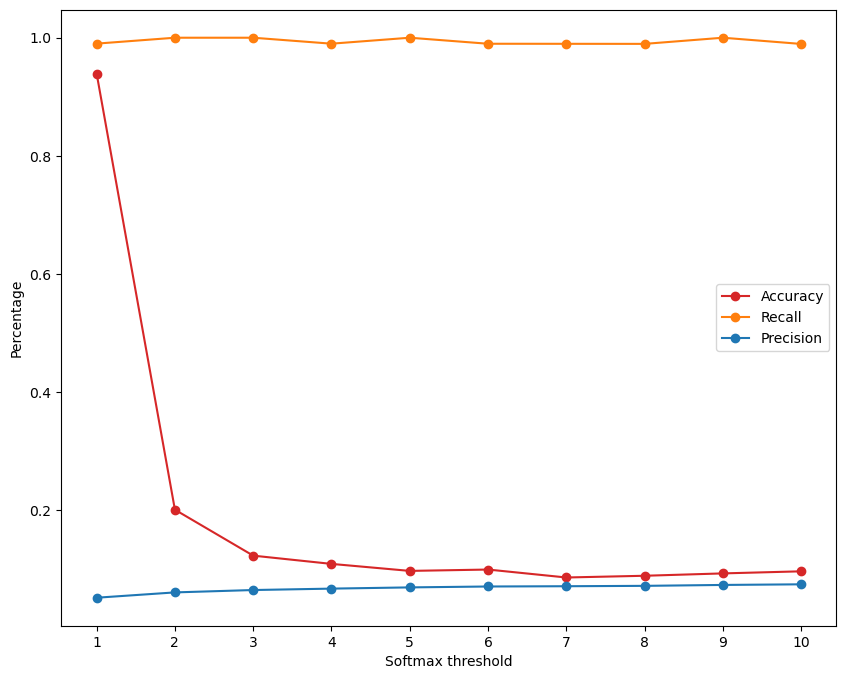

In [56]:
iter_num = 10
softmax_thr = 0.5
chkpt_epoch = 5

accuracy_list = [None]*iter_num
recall_list = [None]*iter_num
precision_list = [None]*iter_num

# class_model.load_state_dict(torch.load('rois2/models/round3_model_epoch{}.pth'.format(chkpt_epoch)))
class_model.load_state_dict(torch.load(model2_result_dir + 'round3_model_epoch' + str(chkpt_epoch) + '.pth'))
class_model.eval()

for j in range(iter_num):
    print('iter: ', j + 1)
    print('current dataset length: ', len(full_input_list))
    temp_dataset = TempDataset(full_input_list)
    temp_loader = DataLoader(temp_dataset, batch_size=32, shuffle=False)
    correct = 0
    total = 0
    true_pos_obj = 0
    correct_pos_pred = 0
    pos_pred = 0
    
    next_input_list = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(temp_loader):
            images = images.to('cuda')
            labels = labels.to('cuda')
            outputs = class_model(images)
            outputs = F.softmax(outputs, dim=1)
            outputs = outputs.cpu().numpy()
            outputs = outputs[:,1]
            predicted = (outputs > softmax_thr).astype(int)
            total += labels.size(0)
            correct += (predicted == labels.cpu().numpy()).sum().item()
            true_pos_obj += (labels != bkg).sum().item()
            correct_pos_pred += ((predicted == labels.cpu().numpy()) & (labels.cpu().numpy() != bkg)).sum().item()
            pos_pred += (predicted != bkg).sum().item()
            # from temp_dataset, delete the negative samples that are predicted as negative
            for k in range(len(predicted)):
                if predicted[k] == 1:
                    next_input_list.append(full_input_list[i*32 + k])

            if(i+1) % 100 == 0 or i == len(temp_loader)-1:
                
                print('         Image [{}/{}], Accuracy: {:.2f} %, Recall: {:.2f} %, Precision: {:.2f} %'
                        .format(i+1, len(temp_loader), 100 * correct / total, 100 * correct_pos_pred / true_pos_obj, 100 * correct_pos_pred / pos_pred))
                # print('         total: ', total, 'correct: ', correct, 'true_pos_obj: ', true_pos_obj, 'correct_pos_pred: ', correct_pos_pred, 'pos_pred: ', pos_pred， '\n')
                
    accuracy = correct / total
    recall = correct_pos_pred / true_pos_obj
    precision = correct_pos_pred / pos_pred  

    accuracy_list[j] = accuracy
    recall_list[j] = recall
    precision_list[j] = precision
             
    print(' total: ', total, 'correct: ', correct, 'true_pos_obj: ', true_pos_obj, 'correct_pos_pred: ', correct_pos_pred, 'pos_pred: ', pos_pred)
    print(' Accuracy: {} % '.format(100 * accuracy))
    print(' Recall: {} % '.format(100 * recall))
    print(' Precision: {} % '.format(100 * precision))   
    
    full_input_list = next_input_list 

plt.figure(figsize=(10, 8))
x_axis = np.arange(1, iter_num+1)
plt.plot(x_axis, accuracy_list, marker='o',label = 'Accuracy', color='tab:red')
plt.plot(x_axis, recall_list, marker='o', label = 'Recall', color='tab:orange')
plt.plot(x_axis, precision_list, marker='o', label = 'Precision', color='tab:blue')
plt.xlabel('Softmax threshold')
plt.ylabel('Percentage')
plt.xticks(x_axis)
plt.legend()
plt.show()
plt.close('all')

In [45]:


softmax_thr_list = [0.5]
epoch_list = [5]

for epoch in epoch_list:
    print('Epoch [{}/{}]'.format(epoch, len(epoch_list)))
    accuracy_list = [None]*len(softmax_thr_list)
    recall_list = [None]*len(softmax_thr_list)
    precision_list = [None]*len(softmax_thr_list)
    for j, softmax_thr in enumerate(softmax_thr_list):
        print('     Softmax Threshold [{}]'.format(softmax_thr))
        class_model.load_state_dict(torch.load(model2_result_dir + 'round3_model_epoch' + str(epoch) + '.pth'))
        class_model.eval()
        # Calculate accuracy
        correct = 0
        total = 0
        # Calculate recall
        true_pos_obj = 0
        correct_pos_pred = 0
        pos_pred = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(val_loader):
                images = images.to('cuda')
                labels = labels.to('cuda')
                outputs = class_model(images)
                outputs = F.softmax(outputs, dim=1)
                outputs = outputs.cpu().numpy()
                outputs = outputs[:,1]
                predicted = (outputs > softmax_thr).astype(int)
                total += labels.size(0)
                correct += (predicted == labels.cpu().numpy()).sum().item()
                true_pos_obj += (labels != bkg).sum().item()
                correct_pos_pred += ((predicted == labels.cpu().numpy()) & (labels.cpu().numpy() != bkg)).sum().item()
                pos_pred += (predicted != bkg).sum().item()

                if(i+1) % 500 == 0 or i == len(val_loader)-1:
                    print('         Image [{}/{}], Accuracy: {:.2f} %, Recall: {:.2f} %, Precision: {:.2f} %'
                            .format(i+1, len(val_loader), 100 * correct / total, 100 * correct_pos_pred / true_pos_obj, 100 * correct_pos_pred / pos_pred))
        accuracy = correct / total
        recall = correct_pos_pred / true_pos_obj
        precision = correct_pos_pred / pos_pred  
        
        accuracy_list[j] = accuracy
        recall_list[j] = recall
        precision_list[j] = precision
         
        print('\n')        
        print('total: ', total, 'correct: ', correct, 'true_pos_obj: ', true_pos_obj, 'correct_pos_pred: ', correct_pos_pred, 'pos_pred: ', pos_pred)
        print('Accuracy of the network on the validation images: {} % '.format(100 * accuracy))
        print('Recall of the network on the validation images: {} % '.format(100 * recall))
        print('Precision of the network on the validation images: {} % '.format(100 * precision))    
        
        plt.figure(figsize=(10, 8))
        plt.title('Epoch: ' + str(epoch))
        plt.plot(softmax_thr_list, accuracy_list, marker='o',label = 'Accuracy', color='tab:red')
        plt.plot(softmax_thr_list, recall_list, marker='o', label = 'Recall', color='tab:orange')
        plt.plot(softmax_thr_list, precision_list, marker='o', label = 'Precision', color='tab:blue')
        plt.xlabel('Softmax threshold')
        plt.ylabel('Percentage')
        plt.xticks(softmax_thr_list)
        plt.legend()
        plt.show()
        plt.close('all')
        

Epoch [5/1]
     Softmax Threshold [0.5]
         Image [500/2000], Accuracy: 94.13 %, Recall: 97.68 %, Precision: 62.64 %


KeyboardInterrupt: 